In [2]:
import os, psutil

# Determine number of available (idle) cores
IDLE_THRESHOLD = 20.0  # percent
cpu_usages = psutil.cpu_percent(percpu=True, interval=1)
available_cores = sum(usage < IDLE_THRESHOLD for usage in cpu_usages)
available_cores = max(1, available_cores) - 4 # At least 1

available_cores = os.cpu_count()

import mplfinance
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Stable-Baselines3 imports
from stable_baselines3 import PPO,A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv  # Use this instead of DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

# Gymnasium (updated from Gym)
import gymnasium as gym
from gymnasium import Env,Wrapper
from gymnasium.spaces import Discrete, Box


In [3]:
# Load Data
df = pd.read_csv("MGOL.csv")  # Replace with actual file
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%y %H:%M')
df.set_index('datetime', inplace=True)

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df.index = df.index + pd.Timedelta(hours=3)
df.index.name = 'Date'
df = df.drop(columns=['symbol', 'frame'])
df = df.iloc[:10]  # Select the first 30 rows
df_original = df
df = df[["close"]]



In [5]:
# latest DebugCallback
from stable_baselines3.common.callbacks import BaseCallback
import torch
import numpy as np

class DebugCallback(BaseCallback):
    def __init__(self, debug_episodes=None, verbose=0, debug=True):
        super().__init__(verbose)
        self.debug_episodes = set(debug_episodes) if debug_episodes is not None else set()
        self.episode_counts = []
        self.episode_step_counts = {}
        self.debug = debug
        self.debug_triggered = False
        self.debug_on_step = None
        self.last_printed_episodes = []
        self.max_episode_steps = {}
        self.action_probs = []
        self.actions = []
        self.episode_data = {}  # Store data per episode

    def _init_callback(self) -> None:
        n_envs = self.training_env.num_envs
        self.episode_counts = [0] * n_envs
        self.last_printed_episodes = [None] * n_envs
        self.episode_step_counts = {i: 0 for i in range(n_envs)}
        self.max_episode_steps = {i: 0 for i in range(n_envs)}
        self.episode_data = {i: {'actions': [], 'probs': [], 'rewards': []} for i in range(n_envs)}

    def _on_training_start(self) -> None:
        num_envs = getattr(self.training_env, "num_envs", 1)
        self.episode_counts = [0] * num_envs
        self.current_episode_steps = [0] * num_envs

    def on_training_end(self) -> None:
        for env_id, max_steps in self.max_episode_steps.items():
            if self.debug: 
                print(f"\n=== Training Summary (Env {env_id}) ===")
                print(f"Max steps in episode: {max_steps}")
                print(f"Total episodes completed: {self.episode_counts[env_id]}")
                print(f"Debug episodes: {sorted(self.debug_episodes)}")

    def _on_step(self) -> bool:
        dones = self.locals.get("dones", [])
        infos = self.locals.get("infos", [])
        actions = self.locals.get("actions", [])
        
        # Get action probabilities
        with torch.no_grad():
            obs_tensor = torch.as_tensor(self.locals.get("new_obs"), device=self.model.device)
            action_probs = self.model.policy.get_distribution(obs_tensor).distribution.probs
            if isinstance(action_probs, torch.Tensor):
                action_probs = action_probs.cpu().numpy()

        for i in range(len(dones)):
            if i not in self.episode_step_counts:
                self.episode_step_counts[i] = 0
                self.episode_data[i] = {'actions': [], 'probs': [], 'rewards': []}

            self.episode_step_counts[i] += 1
            episode_num = self.episode_counts[i]

            # Store action and probabilities
            if i < len(actions) and i < len(action_probs):
                self.episode_data[i]['actions'].append(actions[i])
                self.episode_data[i]['probs'].append(action_probs[i])
                if 'rewards' in self.locals:
                    self.episode_data[i]['rewards'].append(self.locals['rewards'][i] if isinstance(self.locals['rewards'], (list, np.ndarray)) else self.locals['rewards'])

            # Track max steps
            if self.episode_step_counts[i] > self.max_episode_steps[i]:
                self.max_episode_steps[i] = self.episode_step_counts[i]

            # Debug output for specified episodes
            if episode_num in self.debug_episodes and i == 0:
                if self.last_printed_episodes[i] != episode_num:
                    print(f"\n=== Debugging Episode {episode_num} (Env {i}) ===")
                    self.last_printed_episodes[i] = episode_num
                
                # Print step information
                print(f"\nStep {self.episode_step_counts[i]}:")
                print(f"Action: {actions[i] if i < len(actions) else 'N/A'}")
                if i < len(action_probs):
                    print("Action Probabilities:")
                    for action_idx, prob in enumerate(action_probs[i]):
                        print(f"  Action {action_idx}: {prob:.4f}")
                print(f"Reward: {infos[i].get('reward', 'N/A') if i < len(infos) else 'N/A'}")
                print(f"Done: {dones[i] if i < len(dones) else 'N/A'}")
                if i < len(infos):
                    print("Info:", {k: v for k, v in infos[i].items() if k != 'terminal_observation'})

            # Handle episode completion
            if dones[i] and i < len(self.episode_data):
                if episode_num in self.debug_episodes and i == 0:
                    print(f"\n=== Episode {episode_num} (Env {i}) Summary ===")
                    print(f"Total steps: {self.episode_step_counts[i]}")
                    print(f"Actions taken: {self.episode_data[i]['actions']}")
                    print("Action probabilities history:")
                    for step, probs in enumerate(self.episode_data[i]['probs']):
                        print(f"  Step {step + 1}: {probs}")
                    print(f"Rewards: {self.episode_data[i]['rewards']}")
                    print(f"Total reward: {sum(self.episode_data[i]['rewards']):.2f}")
                
                # Reset for next episode
                self.episode_counts[i] += 1
                self.episode_step_counts[i] = 0
                self.episode_data[i] = {'actions': [], 'probs': [], 'rewards': []}

        return True

In [6]:
# latest RewardCallback
class RewardCallback(BaseCallback):
    def __init__(self, debug=False, verbose=0):
        super().__init__(verbose)
        self.debug = debug
        self.n_envs = None
        self.episode_count = 0
        self.episode_count_per_env = None
        self.total_steps_per_env = None
        
        # New tracking
        self.current_episode_rewards = None
        self.episode_rewards = None
        self.invalid_actions = None
        self.current_steps = None
        self.total_steps = 0

    def _on_training_start(self) -> None:
        self.n_envs = self.training_env.num_envs
        self.episode_rewards = []
        self.episode_invalid_actions = []
        self.episode_count_per_env = [0 for _ in range(self.n_envs)]
        self.total_steps_per_env = [0 for _ in range(self.n_envs)]
        self.episode_reward_per_env = [0.0 for _ in range(self.n_envs)]
        self.invalid_actions_per_env = [0 for _ in range(self.n_envs)]
        self.current_steps_per_env = [0 for _ in range(self.n_envs)]

    def _on_step(self) -> bool:
        rewards = self.locals["rewards"]
        dones = self.locals["dones"]
        infos = self.locals["infos"]

        for i in range(self.n_envs):
            # Increment step counters for every step
            self.current_steps_per_env[i] += 1
            self.total_steps += 1
            self.total_steps_per_env[i] += 1
            
            # Update rewards and check for invalid actions
            self.episode_reward_per_env[i] += rewards[i]
            
            if infos[i].get("is_invalid", False):
                self.invalid_actions_per_env[i] += 1

            # Handle episode completion
            if dones[i]:
                self.episode_count += 1
                self.episode_count_per_env[i] += 1
                
                if self.debug and i == 0:
                    print(f"[Env {i}] Episode {self.episode_count_per_env[i]} Done. "
                        f"Steps: {self.current_steps_per_env[i]}, "
                        f"Reward: {self.episode_reward_per_env[i]:.2f}, "
                        f"Invalid: {self.invalid_actions_per_env[i]}")

        if all(dones):     
            # Log mean reward across all environments
            self.episode_rewards.append(sum(self.episode_reward_per_env))
            self.episode_invalid_actions.append(sum(self.invalid_actions_per_env))
            total_reward = sum(self.episode_rewards)
            self.logger.record("rewards/total_reward", total_reward)         

        for i in range(self.n_envs):
            if dones[i]:
                self.current_steps_per_env[i] = 0
                self.episode_reward_per_env[i] = 0.0
                self.invalid_actions_per_env[i] = 0

        return True

    def _on_training_end(self) -> None:
        print("\n=== Final Training Summary ===")
        print(f"Number of environments: {self.n_envs}")
        print(f"Total episodes completed: {self.episode_count}")
        print(f"Average episodes per environment: {self.episode_count / self.n_envs:.1f}")
        print(f"Total steps taken: {self.total_steps}")
        print(f"Average steps per episode: {self.total_steps / self.episode_count:.1f}")
        
        for i in range(self.n_envs):
            if self.debug and i == 0:
                print(f"\n[Env {i}] Summary:")
                print(f"Total episodes: {self.episode_count_per_env[i]}")
                print(f"Total steps: {self.total_steps_per_env[i]}")
                print(f"Average steps per episode: {self.total_steps_per_env[i] / self.episode_count_per_env[i]:.1f}")
        
        # Print old format for compatibility
        formatted_rewards = ', '.join(f"{reward:.1f}" for reward in self.episode_rewards)
        formatted_invalid_actions = ', '.join(str(invalid) for invalid in self.episode_invalid_actions)
        print("\nTotal rewards per episode per env:", formatted_rewards)
        print("Invalid actions per episode per env:", formatted_invalid_actions)

        # Group by iterations (12 environments at a time)
        n_envs = self.n_envs
        n_iterations = len(self.episode_rewards) // n_envs

        """ print("\n=== Per-Iteration Summary ===")
        for i in range(n_iterations):
            start_idx = i * n_envs
            end_idx = (i + 1) * n_envs
            iter_rewards = self.episode_rewards[start_idx:end_idx]
            iter_invalid = self.episode_invalid_actions[start_idx:end_idx]
            
            print(f"\nIteration {i + 1}:")
            print(f"  Total rewards: {sum(iter_rewards):.1f}")
            print(f"  Total invalid actions: {sum(iter_invalid)}")
            print(f"  Avg reward per env: {np.mean(iter_rewards):.1f}")
            print(f"  Avg invalid per env: {np.mean(iter_invalid):.1f}") """

        # Print overall totals
        print("\n=== Combined Totals ===")
        print(f"Total combined rewards: {sum(self.episode_rewards):.1f}")
        print(f"Total invalid actions: {sum(self.episode_invalid_actions)}")

In [27]:
# TrainingDebugCallback

from stable_baselines3.common.callbacks import BaseCallback

class TrainingDebugCallback(BaseCallback):
    """
    A custom callback that logs important training metrics.
    """
    def __init__(self, verbose=0, log_freq=100, debug = False):
        super().__init__(verbose)
        self.log_freq = log_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_invalid_actions = []
        self.current_episode_reward = 0
        self.current_episode_length = 0
        self.current_episode_invalid_actions = 0
        self.n_calls = 0

    def _on_training_start(self):
        # Initialize lists to track metrics
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_invalid_actions = []

    def _on_step(self):
        # Get info from the environment
        infos = self.locals.get('infos', [{}])
        dones = self.locals.get('dones', [False])
        
        # Track metrics for each environment
        for i, (done, info) in enumerate(zip(dones, infos)):
            # Update metrics
            self.current_episode_reward += info.get('reward', 0)
            self.current_episode_length += 1
            self.current_episode_invalid_actions += 1 if info.get('invalid_action', False) else 0
            
            # If episode is done
            if done:
                self.episode_rewards.append(self.current_episode_reward)
                self.episode_lengths.append(self.current_episode_length)
                self.episode_invalid_actions.append(self.current_episode_invalid_actions)
                
                # Log metrics
                if len(self.episode_rewards) % self.log_freq == 0:
                    mean_reward = np.mean(self.episode_rewards[-self.log_freq:])
                    mean_length = np.mean(self.episode_lengths[-self.log_freq:])
                    mean_invalid = np.mean(self.episode_invalid_actions[-self.log_freq:])
                    
                    print(f"Episode {len(self.episode_rewards)}")
                    print(f"Mean reward: {mean_reward:.2f}")
                    print(f"Mean episode length: {mean_length:.1f}")
                    print(f"Mean invalid actions per episode: {mean_invalid:.2f}")
                    print("---")
                
                # Reset for next episode
                self.current_episode_reward = 0
                self.current_episode_length = 0
                self.current_episode_invalid_actions = 0
        
        self.n_calls += 1
        return True

    def _on_training_end(self):
        # Final summary
        if len(self.episode_rewards) > 0:
            print("\n=== Training Complete ===")
            print(f"Total episodes: {len(self.episode_rewards)}")
            print(f"Mean reward: {np.mean(self.episode_rewards):.2f} ± {np.std(self.episode_rewards):.2f}")
            print(f"Min reward: {np.min(self.episode_rewards):.2f}")
            print(f"Max reward: {np.max(self.episode_rewards):.2f}")
            print(f"Mean episode length: {np.mean(self.episode_lengths):.1f}")
            print(f"Mean invalid actions per episode: {np.mean(self.episode_invalid_actions):.2f}")

In [28]:
# Initialize parallel environments and train model
import torch
import importlib
import trading_env_sb3_ver2b
importlib.reload(trading_env_sb3_ver2b)
from trading_env_sb3_ver2b import TradingEnv
from stable_baselines3.common.callbacks import CallbackList
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.maskable.evaluation import evaluate_policy

# Define the mask_fn to get valid actions from the environment
def mask_fn(env: gym.Env) -> np.ndarray:
    return env.get_action_mask()  # Get valid action mask from the environment

num_cpu = 1

In [29]:


env = TradingEnv(df, debug=True)
env = ActionMasker(env, mask_fn)

# Vectorize and normalize
env = DummyVecEnv([lambda: env])  # Or SubprocVecEnv if using multiple envs
env = VecNormalize(
    env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    clip_reward=10.0
)

model = MaskablePPO(MaskableActorCriticPolicy, env, gamma=0.4, seed=32, verbose=1, tensorboard_log="./tensorboard_logs/")
model.learn(100, tb_log_name="sb3_ppo_debug")

evaluate_policy(model, env, n_eval_episodes=20, reward_threshold=90, warn=False)

Using cpu device
Observation with mask: [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00 1.000e+00 1.000e+00
 0.000e+00]
Step 0:
  - Original Observation (shape (5,)): [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00]
  - Action Mask (shape (3,)): [1. 1. 0.]
  - Combined Observation (shape (8,)): [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00 1.000e+00 1.000e+00
 0.000e+00]
Environment reset: Initial Observation (shape (8,)): [3.386e-01 0.000e+00 1.000e+04 1.000e+04 0.000e+00 1.000e+00 1.000e+00
 0.000e+00]
Logging to ./tensorboard_logs/sb3_ppo_debug_47
Current Step: 0
 Action 1
Buy at price: 0.3386
 Shares: 1000
 Balance: 9661.4
 Market position: 338.6
 Net Worth: 10000.0
 Max Steps: 0
Step: 1, Action: 1, Valid Actions: [0, 1], Action Mask: [1. 1. 0.]
Observation with mask: [3.2650e-01 1.0000e+03 9.6614e+03 1.0000e+04 1.0000e+00 1.0000e+00
 0.0000e+00 1.0000e+00]
Step 1:
  - Original Observation (shape (5,)): [3.2650e-01 1.0000e+03 9.6614e+03 1.0000e+04 1.0000e+00]
  - Action 

AssertionError: Mean reward below threshold: 0.00 < 90.00

In [30]:
debug = False

# --- Function to create the wrapped environment ---
def make_env():
    def _init():
        env = TradingEnv(df)  # Your DataFrame must be accessible here
        return ActionMasker(env, mask_fn)
    return _init

# Create parallel environments using SubprocVecEnv
env = SubprocVecEnv([make_env() for _ in range(num_cpu)])

# Wrap with VecNormalize
env = MaskAwareVecNormalize(
    env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    clip_reward=10.0,
    gamma=0.99,
    training=True  # Set to False during evaluation
)

# Define PPO model with the custom policy using the vectorized environment
ppo_masked_model = PPO(
    MaskedPPOPolicy,  # Custom policy
    env,               # Your environment
    verbose=0,         
    tensorboard_log="./tensorboard_logs/",
    learning_rate=5e-4,
    ent_coef=0.001,      # Small exploration penalty
    gamma=0.99,       # Discount factor for long-term rewards
    gae_lambda=0.95,    # Optimistic advantage estimation (strongly favors long-term)
    n_steps=64,      # Large number of timesteps per iteration
    clip_range=0.1,    # Clipping to allow more aggressive updates
    clip_range_vf=0.1,
    n_epochs=20,       # Number of passes over the data (many epochs to overfit)
    batch_size=32,    # Large batch size for stability in updates
    max_grad_norm=0.5,
    vf_coef=0.5,
    normalize_advantage=False,  # Enable advantage normalization
    policy_kwargs=dict(
        net_arch=dict(pi=[256, 256], vf=[256, 256])  # Larger network to memorize patterns
    )
)

# Train the model with the callback
from multiprocessing import set_start_method
set_start_method('spawn', force=True)

# Initialize the debug callback

training_debug_callback = TrainingDebugCallback()  # Log every 10 episodes
reward_callback = RewardCallback()
debug_episodes = {0, 89}
debug_callback = DebugCallback(debug_episodes=debug_episodes)

callbacks = CallbackList([reward_callback, debug_callback])

# Train the model with the callback
try:
    ppo_masked_model.learn(
        total_timesteps=500000,  # Start with a smaller number for testing
        progress_bar=False,
        tb_log_name="sb3_ppo_debug"
    )
finally:
    try:
        env.close()
    except EOFError:
        print("Warning: env subprocess already crashed, skipping close()")

# Save the model
ppo_masked_model.save('sb3_ppo_model')


NameError: name 'MaskAwareVecNormalize' is not defined

In [18]:
def test_trading_model(model, vec_norm_path, num_episodes=3, render=False):
    """Test the trained trading model with a single DummyVecEnv and return signals.
    
    Args:
        model: Trained PPO model
        vec_norm_path: Path to saved VecNormalize stats (optional)
        num_episodes: Number of episodes to run
        render: Whether to print debug info
        
    Returns:
        tuple: (all_episodes_results, first_episode_signals)
            all_episodes_results: dict containing results from all episodes
            first_episode_signals: dict with 'buy_signals' and 'sell_signals' from first episode
    """
    # Create a single test environment
    def make_test_env():
        env = TradingEnv(df)
        env = ActionMasker(env, mask_fn)
        env = DummyVecEnv([lambda: env])
        
        if vec_norm_path:
            env = VecNormalize.load(vec_norm_path, env)
            env.training = False
            env.norm_reward = False
        
        return env
    
    # Initialize results
    all_episodes_results = {
        'episode_rewards': [],
        'all_buy_signals': [],
        'all_sell_signals': [],
        'actions': [],
        'timesteps': []
    }
    
    # Store first episode signals separately
    first_episode_signals = {
        'buy_signals': [],
        'sell_signals': []
    }
    
    # Set model to evaluation mode
    model.policy.eval()
    
    # Create environment once and reuse
    env = make_test_env()
    
    try:
        for episode in range(num_episodes):
            obs = env.reset()
            done = False
            episode_reward = 0
            step = 0
            
            # Lists to store signals for current episode
            episode_buy_signals = []
            episode_sell_signals = []
            
            if render:
                print(f"\n=== Episode {episode + 1} ===")
                print(f"Initial observation: {obs}")
            
            while not done and step < len(df) - 1:
                try:
                    # Get action mask from the environment
                    action_mask = env.envs[0].env.get_action_mask()
                    
                    # Get action from model
                    with torch.no_grad():
                        obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device)
                        dist = model.policy.get_distribution(obs_tensor)
                        masked_logits = dist.distribution.logits + torch.log(
                            torch.as_tensor(action_mask, dtype=torch.float32, device=model.device) + 1e-8
                        )
                        action = torch.argmax(masked_logits).item()
                    
                    # Step environment
                    new_obs, reward, done, info = env.step([action])
                    
                    # Track signals
                    current_step = info[0].get('current_step', step)
                    current_time = df.index[current_step]
                    
                    if action == 1:  # BUY
                        episode_buy_signals.append(current_time)
                        if render:
                            print(f"Step {step}: BUY at {df['close'].iloc[current_step]:.4f}")
                    elif action == 2:  # SELL
                        episode_sell_signals.append(current_time)
                        if render:
                            print(f"Step {step}: SELL at {df['close'].iloc[current_step]:.4f}")
                    
                    # Store results
                    all_episodes_results['actions'].append(action)
                    all_episodes_results['timesteps'].append(current_step)
                    episode_reward += reward[0] if isinstance(reward, np.ndarray) else reward
                    obs = new_obs
                    step += 1
                    
                except Exception as e:
                    print(f"Error at step {step}: {str(e)}")
                    done = True
                    break
            
            # Store signals for this episode
            all_episodes_results['all_buy_signals'].append(episode_buy_signals)
            all_episodes_results['all_sell_signals'].append(episode_sell_signals)
            all_episodes_results['episode_rewards'].append(episode_reward)
            
            # Store first episode signals separately
            if episode == 0:
                first_episode_signals['buy_signals'] = episode_buy_signals
                first_episode_signals['sell_signals'] = episode_sell_signals
            
            if render:
                print(f"Episode {episode + 1} completed with reward: {episode_reward:.2f}")
                print(f"  Buy signals: {len(episode_buy_signals)}")
                print(f"  Sell signals: {len(episode_sell_signals)}")
            
            # Reset for next episode
            env.reset()
    
    finally:
        # Cleanup
        env.close()
    
    # Print summary
    print("\n=== Test Results ===")
    print(f"Episodes: {num_episodes}")
    if all_episodes_results['episode_rewards']:
        print(f"Mean reward: {np.mean(all_episodes_results['episode_rewards']):.2f} ± {np.std(all_episodes_results['episode_rewards']):.2f}")
    
    # Print signal counts for all episodes
    for i in range(num_episodes):
        print(f"Episode {i+1}: {len(all_episodes_results['all_buy_signals'][i])} buy signals, {len(all_episodes_results['all_sell_signals'][i])} sell signals")
    
    return first_episode_signals

# Then test the model
# Test the model and get results
first_episode_signals = test_trading_model(
    PPO.load("sb3_ppo_model.zip"),
    vec_norm_path="vecnormalize.pkl",
    num_episodes=3, 
    render=True
)

# Access the signals from the first episode
buy_signals = first_episode_signals['buy_signals']
sell_signals = first_episode_signals['sell_signals']

print("\nFirst episode buy signals:", buy_signals)
print("First episode sell signals:", sell_signals)


=== Episode 1 ===
Initial observation: [[ 2.0362396e+00 -9.0626061e-01  8.0337775e-01  4.9388060e-01
  -1.5661801e+00  9.0771191e-06  9.0626061e-01 -9.0626061e-01]]
Step 1: BUY at 0.3265
Step 2: SELL at 0.3288
Step 4: BUY at 0.3124
Step 8: SELL at 0.3137
Episode 1 completed with reward: 3.34
  Buy signals: 2
  Sell signals: 2

=== Episode 2 ===
Initial observation: [[ 2.0362396e+00 -9.0626061e-01  8.0337775e-01  4.9388060e-01
  -1.5661801e+00  9.0771191e-06  9.0626061e-01 -9.0626061e-01]]
Step 1: BUY at 0.3265
Step 2: SELL at 0.3288
Step 4: BUY at 0.3124
Step 8: SELL at 0.3137
Episode 2 completed with reward: 3.34
  Buy signals: 2
  Sell signals: 2

=== Episode 3 ===
Initial observation: [[ 2.0362396e+00 -9.0626061e-01  8.0337775e-01  4.9388060e-01
  -1.5661801e+00  9.0771191e-06  9.0626061e-01 -9.0626061e-01]]
Step 1: BUY at 0.3265
Step 2: SELL at 0.3288
Step 4: BUY at 0.3124
Step 8: SELL at 0.3137
Episode 3 completed with reward: 3.34
  Buy signals: 2
  Sell signals: 2

=== Test Res

In [80]:
def print_env_structure(env, indent=0):
    """Recursively print the environment wrapper structure."""
    prefix = "  " * indent
    print(f"{prefix}└─ {type(env).__name__}")
    
    # Special handling for common wrapper types
    if hasattr(env, 'env'):
        print_env_structure(env.env, indent + 1)
    elif hasattr(env, 'envs') and hasattr(env.envs, '__getitem__'):
        print(f"{prefix}  └─ [0]")  # First sub-environment
        print_env_structure(env.envs[0], indent + 2)

In [ ]:
def test_agent(model, env, buy_signals, sell_signals, num_episodes=1):
    """Test function that handles action masking and tracks rewards."""
    print("Environment structure:")
    print_env_structure(env)
    
    # Helper to safely get base environment
    def get_base_env(env):
        current = env
        while True:
            if hasattr(current, 'envs') and hasattr(current.envs, '__getitem__'):
                current = current.envs[0]
            elif hasattr(current, 'env'):
                current = current.env
            else:
                return current
    
    # Get the base environment
    base_env = get_base_env(env)
    print(f"\nBase environment: {type(base_env).__name__}")
    
    # Check if environment is wrapped with VecNormalize
    vec_norm = None
    current = env
    while hasattr(current, 'env'):
        if hasattr(current, 'obs_rms'):
            vec_norm = current
            break
        current = current.env
    
    # Track rewards across all episodes
    all_episode_rewards = []
    all_episode_actions = []
    all_episode_prices = []
    
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        current_step = 0
        episode_buys = []
        episode_sells = []
        episode_rewards = []
        episode_actions = []
        episode_prices = []
        
        print(f"\n{'='*50}")
        print(f"=== Episode {episode + 1} ===")
        print(f"{'Step':<6} {'Action':<6} {'Price':<10} {'Reward':<10} {'Cumulative':<10}")
        print("-"*45)
        
        cumulative_reward = 0
        
        while not done and current_step < len(df):
            try:
                # Get action mask from the base environment
                action_mask = np.ones(3, dtype=np.float32)
                if hasattr(base_env, 'get_action_mask'):
                    action_mask = base_env.get_action_mask()
                
                # Get action using the model's policy
                with torch.no_grad():
                    # Normalize observation if VecNormalize is used
                    if vec_norm is not None:
                        obs = vec_norm.normalize_obs(obs)
                    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device)
                    dist = model.policy.get_distribution(obs_tensor)
                    masked_logits = dist.distribution.logits + torch.log(
                        torch.as_tensor(action_mask, dtype=torch.float32, device=model.device) + 1e-8
                    )
                    action = torch.argmax(masked_logits).item()
                
                # Step environment
                new_obs, reward, done, info = env.step([action])
                if isinstance(reward, np.ndarray):
                    reward = reward.item()
                
                # Denormalize reward if VecNormalize is used
                if vec_norm is not None:
                    reward = vec_norm.unnormalize_reward(reward)
                
                # Track episode data
                price = df['close'].iloc[current_step]
                cumulative_reward += reward
                episode_rewards.append(reward)
                episode_actions.append(action)
                episode_prices.append(price)
                
                # Print step info
                action_str = "BUY" if action == 1 else "SELL" if action == 2 else "HOLD"
                print(f"{current_step:<6} {action_str:<6} {price:<10.4f} {reward:<10.4f} {cumulative_reward:<10.4f}")
                
                # Track signals
                if action == 1:
                    episode_buys.append(df.index[current_step])
                elif action == 2:
                    episode_sells.append(df.index[current_step])
                
                obs = new_obs
                current_step += 1
                
            except Exception as e:
                print(f"Error at step {current_step}: {str(e)}")
                import traceback
                traceback.print_exc()
                break
        
        # Store episode data
        all_episode_rewards.append(episode_rewards)
        all_episode_actions.append(episode_actions)
        all_episode_prices.append(episode_prices)
        
        # Print episode summary
        total_reward = sum(episode_rewards)
        print(f"\nEpisode {episode + 1} Summary:")
        print(f"  Total reward: {total_reward:.4f}")
        if episode_rewards:
            print(f"  Average reward/step: {total_reward/len(episode_rewards):.4f}")
        print(f"  Buy signals: {len(episode_buys)}")
        print(f"  Sell signals: {len(episode_sells)}")
        print("="*50)
        
        # Add to global signals
        buy_signals.extend(episode_buys)
        sell_signals.extend(episode_sells)
    
    return all_episode_rewards, all_episode_actions, all_episode_pricesdef test_agent(model, env, buy_signals, sell_signals, num_episodes=1):
    """Test function that handles action masking and tracks rewards."""
    print("Environment structure:")
    print_env_structure(env)
    
    # Helper to safely get base environment
    def get_base_env(env):
        current = env
        while True:
            if hasattr(current, 'envs') and hasattr(current.envs, '__getitem__'):
                current = current.envs[0]
            elif hasattr(current, 'env'):
                current = current.env
            else:
                return current
    
    # Get the base environment
    base_env = get_base_env(env)
    print(f"\nBase environment: {type(base_env).__name__}")
    
    # Check if environment is wrapped with VecNormalize
    vec_norm = None
    current = env
    while hasattr(current, 'env'):
        if hasattr(current, 'obs_rms'):
            vec_norm = current
            break
        current = current.env
    
    # Track rewards across all episodes
    all_episode_rewards = []
    all_episode_actions = []
    all_episode_prices = []
    
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        current_step = 0
        episode_buys = []
        episode_sells = []
        episode_rewards = []
        episode_actions = []
        episode_prices = []
        
        print(f"\n{'='*50}")
        print(f"=== Episode {episode + 1} ===")
        print(f"{'Step':<6} {'Action':<6} {'Price':<10} {'Reward':<10} {'Cumulative':<10}")
        print("-"*45)
        
        cumulative_reward = 0
        
        while not done and current_step < len(df):
            try:
                # Get action mask from the base environment
                action_mask = np.ones(3, dtype=np.float32)
                if hasattr(base_env, 'get_action_mask'):
                    action_mask = base_env.get_action_mask()
                
                # Get action using the model's policy
                with torch.no_grad():
                    # Normalize observation if VecNormalize is used
                    if vec_norm is not None:
                        obs = vec_norm.normalize_obs(obs)
                    obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device)
                    dist = model.policy.get_distribution(obs_tensor)
                    masked_logits = dist.distribution.logits + torch.log(
                        torch.as_tensor(action_mask, dtype=torch.float32, device=model.device) + 1e-8
                    )
                    action = torch.argmax(masked_logits).item()
                
                # Step environment
                new_obs, reward, done, info = env.step([action])
                if isinstance(reward, np.ndarray):
                    reward = reward.item()
                
                # Denormalize reward if VecNormalize is used
                if vec_norm is not None:
                    reward = vec_norm.unnormalize_reward(reward)
                
                # Track episode data
                price = df['close'].iloc[current_step]
                cumulative_reward += reward
                episode_rewards.append(reward)
                episode_actions.append(action)
                episode_prices.append(price)
                
                # Print step info
                action_str = "BUY" if action == 1 else "SELL" if action == 2 else "HOLD"
                print(f"{current_step:<6} {action_str:<6} {price:<10.4f} {reward:<10.4f} {cumulative_reward:<10.4f}")
                
                # Track signals
                if action == 1:
                    episode_buys.append(df.index[current_step])
                elif action == 2:
                    episode_sells.append(df.index[current_step])
                
                obs = new_obs
                current_step += 1
                
            except Exception as e:
                print(f"Error at step {current_step}: {str(e)}")
                import traceback
                traceback.print_exc()
                break
        
        # Store episode data
        all_episode_rewards.append(episode_rewards)
        all_episode_actions.append(episode_actions)
        all_episode_prices.append(episode_prices)
        
        # Print episode summary
        total_reward = sum(episode_rewards)
        print(f"\nEpisode {episode + 1} Summary:")
        print(f"  Total reward: {total_reward:.4f}")
        if episode_rewards:
            print(f"  Average reward/step: {total_reward/len(episode_rewards):.4f}")
        print(f"  Buy signals: {len(episode_buys)}")
        print(f"  Sell signals: {len(episode_sells)}")
        print("="*50)
        
        # Add to global signals
        buy_signals.extend(episode_buys)
        sell_signals.extend(episode_sells)
    
    return all_episode_rewards, all_episode_actions, all_episode_prices

In [169]:
# Output results from one model

# Initialize lists to store buy and sell signals

def create_test_env(df):

    # Create base environment
    env = TradingEnv(df)
    
    # Apply action masking
    env = ActionMasker(env, mask_fn)
    
    # Convert to vectorized environment (even though it's just 1 env)
    env = DummyVecEnv([lambda: env])
    
    env = VecNormalize(
        env,
        norm_obs=True,
        norm_reward=True,
        clip_obs=10.0,
        clip_reward=10.0,
        gamma=0.99,
        training=False  # Set to False for testing
    )
    
    return env

# Example usage:
test_env = create_test_env(df)


buy_signals = []
sell_signals = []

print("Recording signals")
test_agent(ppo_masked_model, test_env, buy_signals, sell_signals)

Recording signals
Environment structure:
└─ VecNormalize
  └─ [0]
    └─ ActionMasker
      └─ TradingEnv

Base environment: TradingEnv

=== Episode 1 ===
Step   Action Price      Reward     Cumulative
---------------------------------------------
0      HOLD   0.3386     0.0000     0.0000    
1      HOLD   0.3265     0.0000     0.0000    
2      HOLD   0.3288     0.0000     0.0000    
3      HOLD   0.3123     0.0000     0.0000    
4      HOLD   0.3124     0.0000     0.0000    
5      HOLD   0.3011     0.0000     0.0000    
6      HOLD   0.3069     0.0000     0.0000    
7      HOLD   0.3115     0.0000     0.0000    
8      HOLD   0.3137     0.0000     0.0000    
9      HOLD   0.3046     0.0000     0.0000    

Episode 1 Summary:
  Total reward: 0.0000
  Average reward/step: 0.0000
  Buy signals: 0
  Sell signals: 0


([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[np.float64(0.3386),
   np.float64(0.3265),
   np.float64(0.3288),
   np.float64(0.3123),
   np.float64(0.3124),
   np.float64(0.3011),
   np.float64(0.3069),
   np.float64(0.3115),
   np.float64(0.3137),
   np.float64(0.3046)]])

In [172]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Create a test environment with the same wrappers as training
def make_test_env():
    env = TradingEnv(df)  # Your custom environment
    env = ActionMasker(env, mask_fn)  # Apply action masking
    env = DummyVecEnv([lambda: env])  # Vectorized environment
    env = VecNormalize.load("vec_normalize.pkl", env)  # Load saved normalization
    env.training = False  # Important: disable training mode
    env.norm_reward = True  # Optional: disable reward normalization if you want raw rewards
    return env

# Create test environment
test_env = make_test_env()

# Evaluate
mean_reward, std_reward = evaluate_policy(
    ppo_masked_model,
    test_env,
    n_eval_episodes=10,
    deterministic=True
)

print(f"Mean reward over 10 episodes: {mean_reward:.2f} +/- {std_reward:.2f}")

AssertionError: spaces must have the same shape

In [ ]:
# Ensure directories exist
import os
import joblib  # or import pickle
from itertools import product


os.makedirs("./tensorboard_logs/", exist_ok=True)
os.makedirs("./saved_models/", exist_ok=True)

def evaluate_model(model, env, num_episodes=10):
    total_rewards = []
    for _ in range(num_episodes):
        # Access the environment wrapped by DummyVecEnv and ActionMasker
        env_inner = env.get_attr("env", 0)[0]  # Get the first environment
        
        # Check if env_inner has an 'env' attribute (i.e., it's wrapped)
        if hasattr(env_inner, "env"):  
            env_inner = env_inner.env  # Unwrap ActionMasker if applicable

        obs, info = env_inner.reset()  # Reset the environment
        episode_reward = 0
        done = False

        while not done:
            for i in range(30):  # Run for a fixed number of steps
                # Extract the action mask from the original environment
                action_mask = env_inner.get_action_mask()  # Access get_action_mask from TradingEnv inside ActionMasker
    
                # Convert observation and mask to tensors
                obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=model.device).unsqueeze(0)
                action_mask_tensor = torch.as_tensor(action_mask, dtype=torch.float32, device=model.device).unsqueeze(0)
    
                # Predict action with action masking
                with torch.no_grad():
                    action, _, _ = model.policy.forward(obs_tensor, action_mask=action_mask_tensor, deterministic=True)
    
                action = action.cpu().numpy()[0]  # Convert action tensor to numpy
    
                # Step the environment
                obs, reward, done, truncated, info = env_inner.step(action)
    
                episode_reward += reward

                if done or truncated:  # If the episode ends, reset the environment
                    print(f"🎯 Total Reward: {episode_reward:.2f}")
                    obs = env_inner.reset()  # Reset environment, which only returns the observation
                    break  # Exit loop if episode ends

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)

# Perform grid search
results = []
models = []

# Define hyperparameter ranges
ent_coef_range = [0.0]       # Lower values for stability
gamma_range = [0.99]              # Lower values for short-term focus
gae_lambda_range = [0.9]        # Wider range to test variance
n_steps_range = [4096]           # Larger values for more experiences
clip_range_range = [0.1]         # Narrower range for stability
n_epochs_range = [5]               # Fewer epochs for faster training
batch_size_range = [128]           # Larger batches for better performance

force = True

timesteps = 500000

for ent_coef, gamma, gae_lambda, n_steps, clip_range, n_epochs, batch_size in product(
    ent_coef_range, gamma_range, gae_lambda_range, n_steps_range, clip_range_range, n_epochs_range, batch_size_range
):
    model_filename = f"./saved_models/model_ent_coef={ent_coef}_gamma={gamma}_gae_lambda={gae_lambda}_n_steps={n_steps}_clip_range={clip_range}_n_epochs={n_epochs}_batch_size={batch_size}_timesteps={timesteps}.zip"
    
    if os.path.exists(model_filename) and not force:
        print(f"Model already exists: {model_filename}, loading instead of training...")
        model = PPO.load(model_filename, env=env)  # Load existing model
    else:
        print(f"Training new model with: ent_coef={ent_coef}, gamma={gamma}, gae_lambda={gae_lambda}, "
              f"n_steps={n_steps}, clip_range={clip_range}, n_epochs={n_epochs}, batch_size={batch_size}, timesteps={timesteps}")
    
        model = PPO(
            MaskedPPOPolicy,  # Replace with your policy (e.g., "MlpPolicy" or "CnnPolicy")
            env,
            ent_coef=ent_coef,
            gamma=gamma,
            gae_lambda=gae_lambda,
            n_steps=n_steps,
            clip_range=clip_range,
            n_epochs=n_epochs,
            batch_size=batch_size,
            verbose=0,  # Set to 0 for less output
            tensorboard_log="./tensorboard_logs/"
        )
        
        # Train for x timesteps
        model.learn(total_timesteps=timesteps)
    
        # Save the model
        model.save(model_filename)
        print(f"Model saved: {model_filename}")
    
        # Store the model and its parameters
        models.append({
            "model_filename": model_filename,  # Store the path to the saved model
            "params": {
                "ent_coef": ent_coef,
                "gamma": gamma,
                "gae_lambda": gae_lambda,
                "n_steps": n_steps,
                "clip_range": clip_range,
                "n_epochs": n_epochs,
                "batch_size": batch_size,
            }
        })

    # Evaluate the model
    total_reward = evaluate_model(model, env)
    print('Average total reward:', total_reward)

    env.close()  # Close all subprocesses
    
    results.append({
        "ent_coef": ent_coef,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "n_steps": n_steps,
        "clip_range": clip_range,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "total_reward": total_reward,
        "model_filename": model_filename  # Link results to the saved model
    })

# Save results to a CSV file
results_df = pd.DataFrame(results)
csv_filename = f"grid_search_results_{timesteps}_steps.csv"
results_df.to_csv(csv_filename, index=False)

base_csv, csv_ext = os.path.splitext(csv_filename)

# Append a counter if the file already exists
counter = 1
while os.path.exists(csv_filename):
    csv_filename = f"{base_csv}_{counter}{csv_ext}"
    counter += 1

# Save the results DataFrame to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Now, do the same for the models file
models_filename = "./saved_models/models_list.joblib"
base_model, model_ext = os.path.splitext(models_filename)

counter = 1
while os.path.exists(models_filename):
    models_filename = f"{base_model}_{counter}{model_ext}"
    counter += 1

# Save the models variable
joblib.dump(models, models_filename)
print(f"Models saved to {models_filename}")

print("Grid search completed. Results saved to", csv_filename)

In [19]:
buy_signals

[Timestamp('2025-02-07 04:01:00'), Timestamp('2025-02-07 04:04:00')]

In [20]:
sell_signals

[Timestamp('2025-02-07 04:02:00'), Timestamp('2025-02-07 04:08:00')]

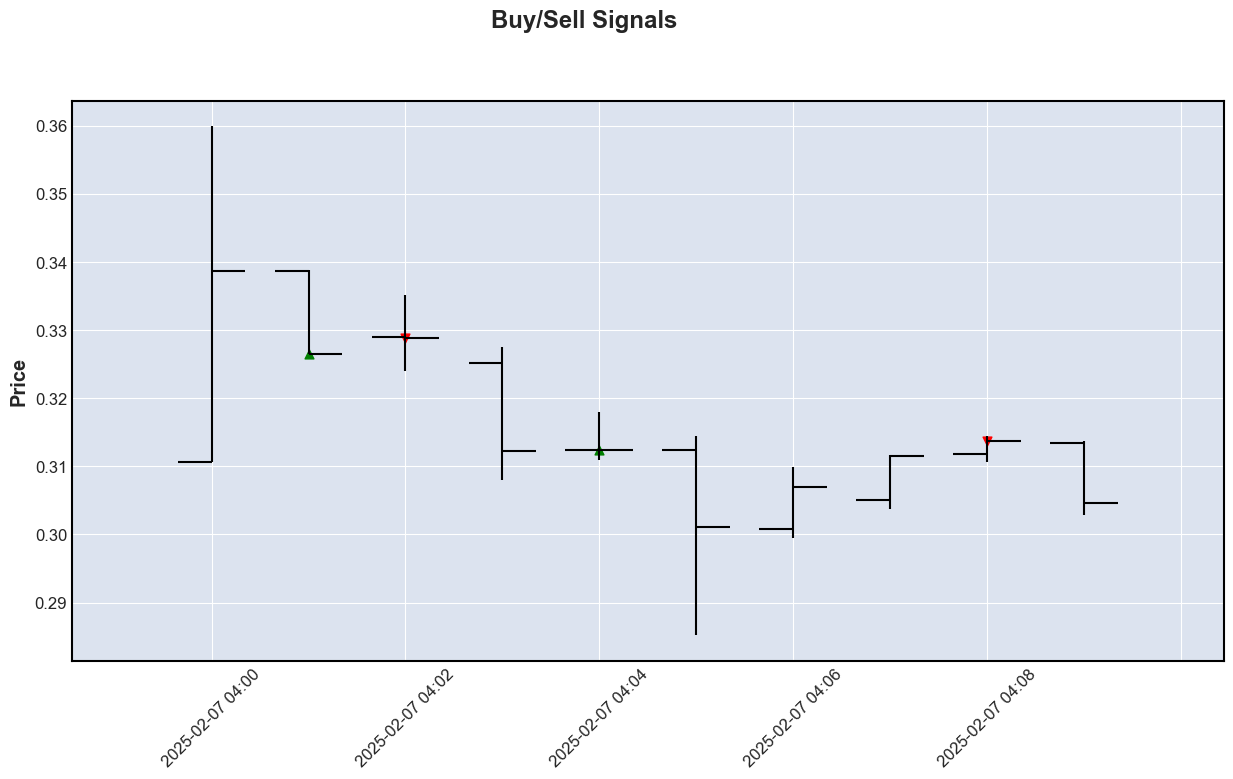

In [21]:
# Show learned buy and sell signals

import mplfinance as mpf
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, buy_signals_1000, sell_signals_1000, buy_signals_10000, and sell_signals_10000 are your lists of timestamps

# Function to plot the signals for a given buy and sell signal list
def plot_signals(buy_signals, sell_signals, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df_original.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df_original.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df_original['close'].copy()
    buy_signal_prices[~df_original.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN
    
    sell_signal_prices = df_original['close'].copy()
    sell_signal_prices[~df_original.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df_original,
        type='ohlc',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(16, 8),
        warn_too_much_data=10000,
        title=title #Adjust the size again to maintain consistency
    )

plot_signals(buy_signals, sell_signals, title="Buy/Sell Signals")


In [ ]:
# Function to calculate profit based on buy and sell signals
def calculate_profit(buy_signals, sell_signals, df):
    buy_prices = df.loc[buy_signals, 'close']
    sell_prices = df.loc[sell_signals, 'close']

    # Ensure that the number of buy signals is less than or equal to the number of sell signals
    min_length = min(len(buy_prices), len(sell_prices))

    # Calculate profit for each pair of buy and sell signals
    profits = []
    for i in range(min_length):
        profit = sell_prices.iloc[i] - buy_prices.iloc[i]  # Profit = Sell Price - Buy Price
        profits.append(profit)

    total_profit = sum(profits)
    return total_profit, profits

# Function to plot the signals and compare profits
def plot_signals_and_compare_profit(buy_signals, sell_signals, df, title):
    # Convert buy/sell signals to DatetimeIndex
    buy_signals = pd.to_datetime(buy_signals)  
    buy_signals = buy_signals[buy_signals.isin(df.index)]  # Filter buy signals to match df.index

    sell_signals = pd.to_datetime(sell_signals)  
    sell_signals = sell_signals[sell_signals.isin(df.index)]  # Filter sell signals to match df.index

    # Create new columns to mark the buy and sell signals with NaN for non-signals
    buy_signal_prices = df['close'].copy()
    buy_signal_prices[~df.index.isin(buy_signals)] = float('nan')  # Set non-buy signals to NaN

    sell_signal_prices = df['close'].copy()
    sell_signal_prices[~df.index.isin(sell_signals)] = float('nan')  # Set non-sell signals to NaN

    # Create addplots for buy and sell signals
    buy_signal_plot = mpf.make_addplot(buy_signal_prices, type='scatter', markersize=40, marker='^', color='green')
    sell_signal_plot = mpf.make_addplot(sell_signal_prices, type='scatter', markersize=40, marker='v', color='red')

    # Plot with the added buy and sell signals
    fig, axes = mpf.plot(
        df,
        type='ohlc',
        style='charles',
        datetime_format='%Y-%m-%d %H:%M',
        addplot=[buy_signal_plot, sell_signal_plot],
        returnfig=True,
        figsize=(20, 10),
        warn_too_much_data=1000  # Adjust the size again to maintain consistency
    )

    # Customize x-axis
    #axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    #plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add legend manually
    #plt.legend(['Buy Signals', 'Sell Signals'], loc='upper left')

    # Add title
    #plt.title(title)

    # Show the plot
    #plt.show()

    # Calculate and print profit for the signals
    total_profit, profits = calculate_profit(buy_signals, sell_signals, df)
    print(f"Total Profit for {title}: {total_profit:.2f}")
    return total_profit

# Calculate and plot for 1000 timesteps signals
profit_1000 = plot_signals_and_compare_profit(buy_signals_1000, sell_signals_1000, df, title="Profit for 1000 Timesteps")

# Calculate and plot for 10000 timesteps signals
profit_10000 = plot_signals_and_compare_profit(buy_signals_10000, sell_signals_10000, df, title="Profit for 10000 Timesteps")

# Calculate and plot for 100000 timesteps signals
#profit_100000 = plot_signals_and_compare_profit(buy_signals_100000, sell_signals_100000, df, title="Profit for 100000 Timesteps")


# Compare the total profits
print(f"Total Profit for 1000 Timesteps: {profit_1000:.2f}")
print(f"Total Profit for 10000 Timesteps: {profit_10000:.2f}")
#print(f"Total Profit for 100000 Timesteps: {profit_100000:.2f}")